# Lecture 5: Experiments with RecPack Algorithms

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/recpack /content

In [3]:
!unzip /content/drive/MyDrive/transactions_train.zip
!unzip /content/drive/MyDrive/articles.zip
!unzip /content/drive/MyDrive/customers.zip

Archive:  /content/drive/MyDrive/transactions_train.zip
  inflating: transactions_train.feather  
Archive:  /content/drive/MyDrive/articles.zip
  inflating: articles.feather        
Archive:  /content/drive/MyDrive/customers.zip
  inflating: customers.feather       


In [4]:
import numpy as np 
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import string
import seaborn as sns

### In order to achieve a better perfomance in RAM and running time, we convert the CSV datasets into Feather format.

In [ ]:
#https://medium.com/@rajkrakesh/feather-vs-csv-829472196832
transactions = pd.read_csv('transactions_train.csv.zip').to_feather('transactions_train.feather')

In [ ]:
articles = pd.read_csv('articles.csv.zip')
customers = pd.read_csv('customers.csv.zip')

In [ ]:
articles.to_feather('articles.feather')

In [ ]:
customers.to_feather('customers.feather')

In [6]:
articles = pd.read_feather('articles.feather')
customers = pd.read_feather('customers.feather')
transactions = pd.read_feather('transactions_train.feather')

### Preprocessing the transaction dataset


In [7]:
#def customer_id_to_int(x): return int(x[-16:], 16)

#transactions['customer_id'] = transactions['customer_id'].apply(customer_id_to_int).astype('int32')
transactions['article_id'] = transactions['article_id'].astype('int32')

In [8]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
#transactions['article_id'] = transactions['article_id'].astype('int32')
#transactions['customer_id'] = transactions['customer_id'].apply(customer_id_to_int).astype('int32')
transactions.sales_channel_id = transactions.sales_channel_id.astype('int8')
transactions.price = transactions.price.astype('float32')

In [9]:
transactions['week'] = 104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7
transactions.week = transactions.week.astype('int8')

last_month = transactions['week'].max() - 8
transactions = transactions.loc[transactions["week"] >= last_month]
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week
29314980,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,778064038,0.008458,2,96
29314981,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,817166007,0.006763,2,96
29314982,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,840360002,0.008458,2,96
29314983,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,817166003,0.008458,2,96
29314984,2020-07-22,00061a04f030bdf3665b09829192ca8c13c4de6dd9ae9d...,624486001,0.012729,2,96
...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2,104
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2,104
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1,104
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1,104


### Preprocessing the article dataset

In [10]:
articles['article_id'] = articles['article_id'].astype('int32')
articles['product_code'] = articles['product_code'].astype('int8')
#articles['prod_name'] = articles['prod_name'].apply(preprocess_text)
#articles['product_group_name'] = pd.factorize(articles['product_group_name'])[0].astype('int8')
articles['product_type_no'] = articles['product_type_no'].astype('int8')
articles['graphical_appearance_no'] = pd.factorize(articles['graphical_appearance_no'])[0].astype('int8')
articles['colour_group_code'] = articles['colour_group_code'].astype('int8')
articles['perceived_colour_value_id'] = articles['perceived_colour_value_id'].astype('int8')
articles['perceived_colour_master_id'] = articles['perceived_colour_master_id'].astype('int8')
articles['department_no'] = articles['department_no'].astype('int8')
articles['index_code'] = pd.factorize(articles['department_no'])[0].astype('int8')
articles['index_group_no'] = articles['index_group_no'].astype('int8')
articles['section_no'] = articles['section_no'].astype('int8')
articles['garment_group_no'] = articles['garment_group_no'].astype('int16')

### Preprocess of customer dataset

In [11]:
customers.fillna({"FN": 0, "Active": 0}, inplace=True)

#def customer_id_to_int(x): return int(x[-16:], 16)
#customers['customer_id'] = customers['customer_id'].apply(customer_id_to_int).astype('int32')

In [12]:
customers["FN"] = customers["FN"].astype('int8')
customers["Active"] = customers["Active"].astype('int8')
customers['age'].fillna(int((customers['age'].mean())), inplace=True)
customers["fashion_news_frequency"] = pd.factorize(customers["fashion_news_frequency"])[0].astype('int8')
customers["club_member_status"] = pd.factorize(customers["club_member_status"])[0].astype('int8')
customers['postal_code'] = pd.factorize(customers['postal_code'])[0].astype('int32')
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,0,0,49.0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,0,0,25.0,1
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,24.0,2
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,54.0,3
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,0,1,52.0,4
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0,0,0,0,24.0,62927
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0,0,0,0,21.0,6316
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1,1,0,1,21.0,273671
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1,1,0,1,18.0,218323


# Merging articles and customers dataset with transaction.

In [13]:
transactions.sort_values(['week', 'customer_id'], inplace=True)

In [15]:
transactions.drop_duplicates(inplace=True)
transactions_merge = transactions.merge(articles, how="inner", on='article_id')
transactions_merge = transactions.merge(customers, how="inner", on='customer_id')
transactions_processed = transactions_merge[['t_dat','customer_id','age','article_id', 'price', 'week']].copy()
transactions_processed.head()

,t_dat,customer_id,age,article_id,price,week
0,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,778064038,0.008458,96
1,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,817166007,0.006763,96
2,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,840360002,0.008458,96
3,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,817166003,0.008458,96
4,2020-07-28,0001076e215991bad544dd3e7312f78d9f576a1cc3ddc4...,22.0,658298001,0.022017,96


In [16]:
transactions_processed = transactions_processed.dropna()

# Candidate Generation

In [17]:
c = customers['customer_id'].unique().tolist()

In [18]:
from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem
from recpack.scenarios import Timed
from recpack.pipelines import PipelineBuilder

# Calculating the popularity for each of the articles

In [19]:
# source: https://github.com/LienM/ai-project-22-23/blob/main/ArnoTroch/lecture4/submission-KNN.ipynb
popularity = transactions_processed.groupby(['article_id', 'week']).size().reset_index(name='purchase_count').groupby(
    'article_id').apply(lambda x: np.sum(x.purchase_count / x.week)).reset_index(name='article_popularity')

# top 12
most_popular_articles = popularity.nlargest(12, 'article_popularity')['article_id'].tolist()


# Creating the interaction matrix with RecPack

In [20]:
proc = DataFramePreprocessor(item_ix='article_id', user_ix='customer_id', timestamp_ix='week')
proc.add_filter(MinUsersPerItem(5, item_ix='article_id', user_ix='customer_id'))
proc.add_filter(MinItemsPerUser(50, item_ix='article_id', user_ix='customer_id'))

interaction_matrix = proc.process(transactions_processed[['article_id', 'customer_id', 'week']])

  0%|          | 0/36285 [00:00<?, ?it/s]

  0%|          | 0/36285 [00:00<?, ?it/s]

# Association Rules algorithm

In [29]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks


def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class AssociationRules(TopKItemSimilarityMatrixAlgorithm):
    def __init__(self, K=200):
        super().__init__(K)

    def _fit(self, X: csr_matrix):
        """
        Trains the predictor.

        """
        X_binary = to_binary(X)
        X_T_binary = csr_matrix(X_binary.transpose())

        # CO_matrix = X_T_binary @ X_binary

        CO_matrix = csr_matrix(X_T_binary @ X_binary)

        # Here we get the best rules
        CO_matrix = get_top_K_values(CO_matrix, self.K)

        # Normalization of CO_matrix
        CO_array = CO_matrix.toarray()

        diag = np.diagonal(CO_array)
        sim_matrix = CO_array/diag[:, None]
        similarity = csr_matrix(sim_matrix)
        # similarity = get_top_K_values(similarity, self.K)

        self.similarity_matrix_ = similarity

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X

# Sequential Rules algorithm

In [30]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary


def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class SequentialRules(ItemSimilarityMatrixAlgorithm):
    def __init__(self, max_steps=20):
        self.max_steps = max_steps

    def _transform_fit_input(self, X: Matrix) -> InteractionMatrix:
        # X_interaction_matrix = isinstance(X, InteractionMatrix)
        if isinstance(X, InteractionMatrix) == False:
            raise ValueError(f"Interaction Matrix")
        elif X.has_timestamps == False:
            raise ValueError(f"requires timestamp information")
        else:
            return X

    def _fit(self, X: InteractionMatrix):
        a = list(X.sorted_item_history)
        sim_matrix = lil_matrix((X.shape[1], X.shape[1]))
        for user, items_per_user in X.sorted_item_history:
            for i in range(0, len(items_per_user) - 1):
                for n_steps, j in enumerate(
                    range(i + 1, min(len(items_per_user), i + self.max_steps + 1)),
                    start=1,
                ):
                    LHS = items_per_user[i]
                    RHS = items_per_user[j]
                    sim_matrix[LHS, RHS] += 1 / n_steps
        support = csr_matrix(X.values.sum(axis=0))

        sim_matrix = sim_matrix.multiply(invert(support).T)
        self.similarity_matrix_ = sim_matrix.tocsr()

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X


# Registering both implemented algorithms.

In [32]:
from recpack.pipelines import ALGORITHM_REGISTRY, PipelineBuilder, pipeline_builder

ALGORITHM_REGISTRY.register('Association_Rules', AssociationRules)
ALGORITHM_REGISTRY.register('Sequential_Rules', SequentialRules)

# Defining the best split, by using scenarios in RecPack

(array([4228., 4921., 4520., 4369.,    0., 3887., 3666., 3747., 3608.,
        3339.]),
 array([ 96. ,  96.8,  97.6,  98.4,  99.2, 100. , 100.8, 101.6, 102.4,
        103.2, 104. ]),
 <a list of 10 Patch objects>)

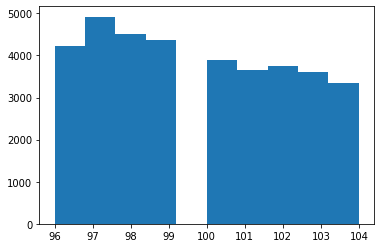

In [24]:
import matplotlib.pyplot as plt
plt.hist(interaction_matrix.timestamps.values)

In [33]:
scenario = Timed(t=101, t_validation=99, delta_out=None, delta_in=None, validation=True) # weeks calculated with calculator.
scenario.split(interaction_matrix)

# Building a Pipeline from RecPack to run and generate the results of the algorithms.

In [34]:
builder = PipelineBuilder()
builder.set_data_from_scenario(scenario)
builder.add_algorithm('Popularity')
builder.add_algorithm('ItemKNN', grid={
    'K': [10, 20, 30, 40],
    'similarity': ['cosine'],
})
builder.add_algorithm('Association_Rules', grid={'K': [100, 200, 300]})
builder.add_algorithm('Sequential_Rules', grid={'max_steps': [20, 30, 40]})
builder.set_optimisation_metric('CoverageK', K=12)
builder.set_optimisation_metric('NDCGK', K=12)
builder.add_metric('CoverageK', K=[10, 20, 30, 40])
builder.add_metric('NDCGK', [10, 20, 30, 40])

In [35]:
pipeline = builder.build()
pipeline.run()

  0%|          | 0/4 [00:00<?, ?it/s]

2022-11-22 22:32:28,433 - base - recpack - INFO - Fitting Popularity complete - Took 0.0122s


INFO:recpack:Fitting Popularity complete - Took 0.0122s


2022-11-22 22:32:28,940 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.279s


INFO:recpack:Fitting ItemKNN complete - Took 0.279s


2022-11-22 22:32:29,316 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.337s


INFO:recpack:Fitting ItemKNN complete - Took 0.337s


2022-11-22 22:32:29,741 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.376s


INFO:recpack:Fitting ItemKNN complete - Took 0.376s


2022-11-22 22:32:30,222 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.42s


INFO:recpack:Fitting ItemKNN complete - Took 0.42s


2022-11-22 22:32:30,704 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.415s


INFO:recpack:Fitting ItemKNN complete - Took 0.415s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


2022-11-22 22:32:38,810 - base - recpack - INFO - Fitting AssociationRules complete - Took 7.86s


INFO:recpack:Fitting AssociationRules complete - Took 7.86s


2022-11-22 22:32:51,734 - base - recpack - INFO - Fitting AssociationRules complete - Took 7.89s


INFO:recpack:Fitting AssociationRules complete - Took 7.89s


2022-11-22 22:33:04,555 - base - recpack - INFO - Fitting AssociationRules complete - Took 7.83s


INFO:recpack:Fitting AssociationRules complete - Took 7.83s


2022-11-22 22:33:14,949 - base - recpack - INFO - Fitting AssociationRules complete - Took 5.4s


INFO:recpack:Fitting AssociationRules complete - Took 5.4s


2022-11-22 22:33:19,671 - base - recpack - INFO - Fitting SequentialRules complete - Took 1.58s


/content/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 5077 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
INFO:recpack:Fitting SequentialRules complete - Took 1.58s
/content/recpack/algorithms/base.py:119: UserWarning: SequentialRules failed to recommend any items for 66 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-11-22 22:33:21,529 - base - recpack - INFO - Fitting SequentialRules complete - Took 1.81s


INFO:recpack:Fitting SequentialRules complete - Took 1.81s


2022-11-22 22:33:23,706 - base - recpack - INFO - Fitting SequentialRules complete - Took 2.13s


INFO:recpack:Fitting SequentialRules complete - Took 2.13s


2022-11-22 22:33:26,371 - base - recpack - INFO - Fitting SequentialRules complete - Took 2.6s


/content/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 3023 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
INFO:recpack:Fitting SequentialRules complete - Took 2.6s
/content/recpack/algorithms/base.py:119: UserWarning: SequentialRules failed to recommend any items for 74 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


# Results

In [36]:
pipeline.get_metrics()

,coveragek_10,coveragek_20,coveragek_30,coveragek_40,ndcgk_10,ndcgk_20,ndcgk_30,ndcgk_40
Popularity(K=200),0.001338,0.002409,0.003747,0.005085,0.010067,0.010245,0.010552,0.012586
"ItemKNN(K=30,normalize_X=False,normalize_sim=False,pop_discount=None,similarity=cosine)",0.225087,0.315461,0.374788,0.412615,0.003145,0.002838,0.002684,0.003380
AssociationRules(K=100),0.126684,0.204835,0.258007,0.310197,0.004176,0.003277,0.003594,0.003622
SequentialRules(max_steps=20),0.153627,0.240075,0.283968,0.314747,0.003751,0.003805,0.003683,0.003747


# ItemKNN used to generate candidates

In [164]:
from recpack.algorithms import ItemKNN
knn = ItemKNN(K=20, similarity='cosine')
knn.fit(interaction_matrix)

2022-11-22 22:16:30,119 - base - recpack - INFO - Fitting ItemKNN complete - Took 76.5s


INFO:recpack:Fitting ItemKNN complete - Took 76.5s


ItemKNN(K=20)

In [165]:
predictions = knn.predict(interaction_matrix)

# Association Rules used to generate candidates

In [37]:
ar = AssociationRules(K=100)
ar.fit(interaction_matrix)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


2022-11-22 22:35:17,854 - base - recpack - INFO - Fitting AssociationRules complete - Took 2.94s


INFO:recpack:Fitting AssociationRules complete - Took 2.94s


AssociationRules(K=100)

In [38]:
pred = ar.predict(interaction_matrix)

# Sequential Rules used to generate candidates

In [43]:
sr = SequentialRules(max_steps=20)
sr.fit(interaction_matrix)

2022-11-22 22:45:36,801 - base - recpack - INFO - Fitting SequentialRules complete - Took 4.61s


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/content/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 76 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
INFO:recpack:Fitting SequentialRules complete - Took 4.61s


SequentialRules()

In [44]:
pred_sr = sr.predict(interaction_matrix)

/content/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 76 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/content/recpack/algorithms/base.py:119: UserWarning: SequentialRules failed to recommend any items for 76 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


In [56]:
def top_n_idx_sparse(matrix, n):
    """
    source: https://stackoverflow.com/questions/49207275/finding-the-top-n-values-in-a-row-of-a-scipy-sparse-matrix
    """
    '''Return index of top n values in each row of a sparse matrix'''
    top_n_idx = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        if n_row_pick == n:
          top_n_idx.append(matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]].tolist())
    return top_n_idx

In [57]:
# https://github.com/LienM/ai-project-22-23/blob/main/ArnoTroch/lecture4/submission-KNN.ipynb
pred_indices = top_n_idx_sparse(pred_sr, 12)
# create a dict with customer_id as key and an empty list as value
prediction_dict = {customer_id: most_popular_articles for customer_id in c}

# use interaction_matrix._df to map back to original customer and article ids
uid_cid_map = interaction_matrix._df[["uid", "customer_id"]].drop_duplicates().set_index("uid").to_dict()["customer_id"]
iid_aid_map = interaction_matrix._df[["iid", "article_id"]].drop_duplicates().set_index("iid").to_dict()["article_id"]

In [59]:
# https://github.com/LienM/ai-project-22-23/blob/main/ArnoTroch/lecture4/submission-KNN.ipynb
for i, row in enumerate(pred_indices):
    user_predictions = [iid_aid_map[iid] for iid in row]
    if len(user_predictions) < 12:
        # add all most popular articles that are not already in the list
        user_predictions.extend([aid for aid in most_popular_articles if aid not in user_predictions])[:12]
    prediction_dict[uid_cid_map[i]] = user_predictions
# create a dataframe with the predictions
df_pred = pd.DataFrame({
    'customer_id': list(prediction_dict.keys()), 
    'prediction': list(" ".join(["0" + str(article) for article in articles]) for articles in prediction_dict.values())
})
#df_pred = df_pred.drop(df_pred.index[range(7)])
df_pred

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0918292001 0372860002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0918292001 0372860002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0918292001 0372860002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0918292001 0372860002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0918292001 0372860002 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0751471001 0706016001 0918292001 0372860002 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0918292001 0372860002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0918292001 0372860002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0918292001 0372860002 07...


In [60]:
df_pred.to_csv('submission_sr.zip', index=False)